In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns


### Load Dataset and Extract Features

### Extract Features for each segment

In [3]:

## Doesn't use fft, revising to have a better extract features set

# def extract_features(segment, sr):

#       # Check if segment is empty
#     if len(segment) == 0 or segment.size == 0:
#         print(f"Warning: Empty segment detected with size {segment.size}")
#         # Return default features or handle this case
#         return None  # or return default features
#     features = []

#     # Time domain features
#     features.append(np.mean(np.abs(segment)))  # Mean absolute amplitude
#     features.append(np.std(segment))           # Standard deviation
#     features.append(np.max(np.abs(segment)))   # Peak amplitude

#     # Spectral features
#     mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
#     features.extend(np.mean(mfccs, axis=1))    # Mean of each MFCC coefficient

#     # Zero crossing rate
#     zcr = librosa.feature.zero_crossing_rate(segment)
#     features.append(np.mean(zcr))

#     # Spectral centroid
#     centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
#     features.append(np.mean(centroid))

#     return features



In [9]:

def extract_features(segment, sr):

      # Check if segment is empty
    if len(segment) == 0 or segment.size == 0:
        print(f"Warning: Empty segment detected with size {segment.size}")
        # Return default features or handle this case
        return None  # or return default features
    features = []

    # Time domain features
    features.append(np.mean(np.abs(segment)))  # Mean absolute amplitude
    features.append(np.std(segment))           # Standard deviation
    fft_coefficients = np.abs(np.fft.fft(segment))[:10] # fft
    features.extend(fft_coefficients)

    return features



In [11]:
# Paths to your audio and CSV files

base_url = '/content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/'
audio_files = [
    base_url + 'audio000.wav',
    base_url + 'audio001.wav',
    #base_url + 'audio002.wav',
    base_url + 'audio003.wav',
    base_url + 'audio004.wav',
    base_url + 'audio005.wav',
    base_url + 'audio006.wav',
    base_url + 'audio007.wav',
    base_url + 'audio008.wav',
]

csv_files = [
    base_url + 'audio000.csv',
    base_url + 'audio001.csv',
    #base_url + 'audio002.csv',
    base_url + 'audio003.csv',
    base_url + 'audio004.csv',
    base_url + 'audio005.csv',
    base_url + 'audio006.csv',
    base_url + 'audio007.csv',
    base_url + 'audio008.csv',
]

# Verify matching files
if len(audio_files) != len(csv_files):
    print(f"Warning: Number of audio files ({len(audio_files)}) doesn't match number of CSV files ({len(csv_files)})")

# Create empty lists for the combined dataset
all_features = []
all_labels = []

# Process each file pair
for audio_file, csv_file in zip(audio_files, csv_files):
    print(f"Processing {audio_file} with {csv_file}")

    # Load audio file
    y, sr = librosa.load(audio_file, sr=None) # Use the original sampling rate

    # Load CSV file with timestamps
    data = pd.read_csv(csv_file)

    # Process each segment in the CSV
    for _, row in data.iterrows():
        # Convert timestamps to sample indices
        start_idx = int(row['Start ts'] * sr)
        end_idx = int(row['End ts'] * sr)

        # Extract audio segment
        segment = y[start_idx:end_idx]

        # Extract features
        segment_features = extract_features(segment, sr)

        # Add to combined dataset
        all_features.append(segment_features)
        all_labels.append(row['Label'])

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)

print(f"Combined dataset shape: {X.shape}")
print(f"Number of labels: {len(y)}")
print(f"Unique labels: {np.unique(y)}")

# Save the combined dataset (optional)
np.save('combined_features.npy', X)
np.save('combined_labels.npy', y)




Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio000.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio000.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio001.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio001.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio003.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio003.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio004.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio004.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio005.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio005.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio006.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio006.csv
Processing /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio007.wav with /content/drive/MyDrive/ML-Sound-Waves/Sound_Wave/audio007.csv
Processing /content/

### Split into Training & Test Data

In [12]:


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])


### Perform KNN cross-validation

In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.28813559 0.15254237 0.15254237 0.13559322 0.22413793]
Mean CV Score: 0.1906
Standard Deviation: 0.0576


### Find best parameters

In [14]:
param_grid = {'knn__n_neighbors': range(1, 31)}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters: {'knn__n_neighbors': 1}
Best Cross-Validation Score: 0.2346


### Cross Validation Scores per K-Values

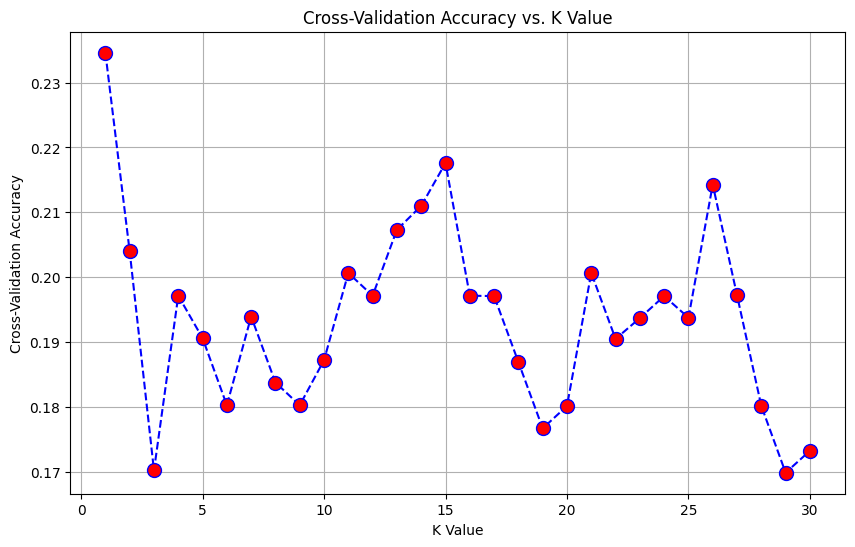

In [15]:
k_values = range(1, 31)
mean_scores = []
for k in k_values:
    pipeline.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Cross-Validation Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()

### Evaluate the Model


Classification Report (Test Set):
                         precision    recall  f1-score   support

collect-Aluminium Metal       0.29      0.23      0.26        22
      collect-Bark Wood       0.37      0.41      0.39        17
    collect-PLA plastic       0.44      0.39      0.41        18
        collect-Textile       0.27      0.35      0.31        17

               accuracy                           0.34        74
              macro avg       0.34      0.35      0.34        74
           weighted avg       0.34      0.34      0.34        74



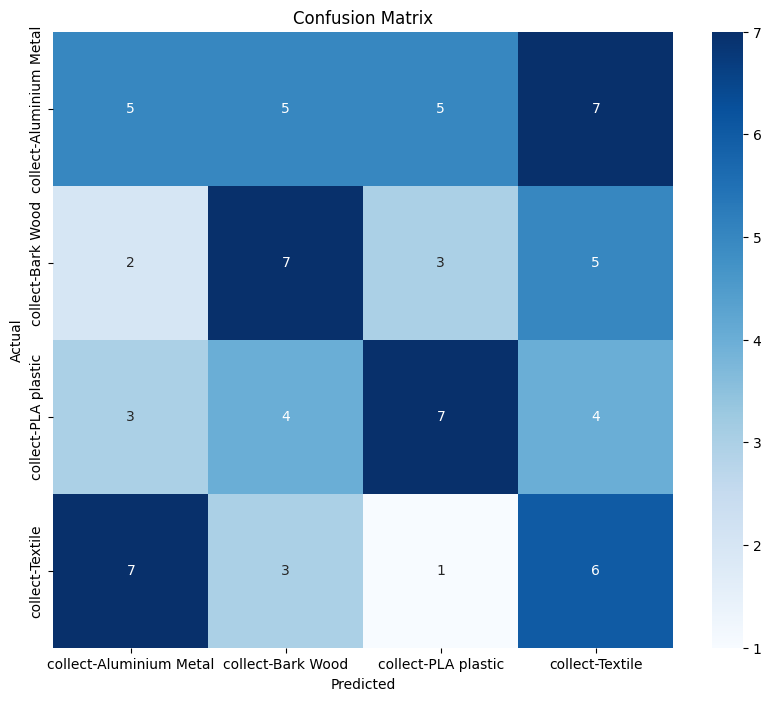

In [16]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 9. Evaluate the model on the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

# 10. Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()